<center>
    <h1>A Real-time Fire Segmentation Method Based on A Deep Learning Approach</h1>
    <h3>Facundo Nicolas Maidana and Riccardo Spolaor</h3>
    <h4>facundo.maidana@studio.unibo.it; riccardo.spolaor@studio.unibo.it</h4>
</center>

---

This notebook presents the flow of an experiment which aims at reproducing the results of the paper [*A Real-time Fire Segmentation Method Based on A Deep Learning Approach*](./docs/A%20Real-time%20Fire%20Segmentation%20Method%20Based%20on%20A%20Deep%20Learning%20Approach.pdf) <a name="cite_paper"></a>[<sup>[1]</sup>](#note_paper).

The paper proposes a novel approach to handle the segmentation of fire in open areas, such as woods or forests that aims at improving the speed in obtaining the results.

The work consists in the development of an improved version of *Deeplabv3+*, which is an encoder-decoder network used for semantic segmentation tasks. Differently from that model, it uses the lightweight *Mobilenetv3* network in the decoding operations to increase the segmentation speed. For the same reason, it also avoids *atrous convolutions* in spite of losing segmemntation accuracy. In order to compensate for this loss the proposed network introduces two additional shallow features to the decoder rich in pattern information of the input images.

For more detailed informations about the used functions, look into the corresponding docstrings inside the python files, inside the `src` folder.

The dataset used in the experiment is available at the following link: https://ieee-dataport.org/open-access/flame-dataset-aerial-imagery-pile-burn-detection-using-drones-uavs.
In particular, the user should download the images of fires (*9) Images for fire segmentation (Train/Val/Test) Images.zip*) and the related masks (*10) Masks annotation for fire segmentation (Train/Val/Test) Masks.zip*) zip files in the section *"Dataset Files"* and copy them in the folder `./data`.

---
<small>

<a name="note_paper"></a>[1] Menga Li et al. “A Real-time Fire Segmentation Method Based on A Deep Learning Approach”. In: *IFAC-PapersOnLine*. 2022. url: https://www.sciencedirect.com/science/article/pii/S2405896322005055.

</small>


<a href="https://colab.research.google.com/github/maidacundo/fire-segmentation-deep-learning/blob/main/FireSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Settings for autoreloading.

%load_ext autoreload
%autoreload 2

In [2]:
# Settings for reproducibility.

from src.utils.seed import set_random_seed

SEED = 42
set_random_seed(SEED)

## Data

https://github.com/AlirezaShamsoshoara/Fire-Detection-UAV-Aerial-Image-Classification-Segmentation-UnmannedAerialVehicle

In [3]:
'''is_colab = True

if is_colab:
    from google.colab import drive
    drive.mount('/content/drive')''';

In [4]:
'''!unzip /content/drive/MyDrive/fire-segmentation/images.zip -d /content
!unzip /content/drive/MyDrive/fire-segmentation/masks.zip -d /content''';

In [5]:
'''!cp /content/drive/MyDrive/fire-segmentation/images.zip -d /content''';

In [6]:
'''!cp /content/drive/MyDrive/fire-segmentation/masks.zip -d /content''';

In [7]:
import numpy as np

In [8]:
RESIZE_SHAPE = (512, 512)

In [9]:
'''import cv2
import os
import re
from zipfile import ZipFile

def load_images_from_zip(zip_file, is_mask, resize_shape=(512, 512)):
    images = []
    # i = 0
    with ZipFile(zip_file) as zf:
        # Get file names list and skip the first folder name.
        file_names = zf.namelist()[1:]
        # Sort the file names by their image number.
        file_names = sorted(
            file_names,
            key=lambda x: int(re.findall(r'[\d]+', x)[0]))

        for file_name in file_names:
            # Read the current file.
            data = zf.read(file_name)
            # Decode the file into a numpy ndarray.
            if is_mask:
                img = cv2.imdecode(np.frombuffer(data, np.uint8),
                                   cv2.IMREAD_GRAYSCALE)
            else:
                img = cv2.imdecode(np.frombuffer(data, np.uint8),
                                   cv2.IMREAD_COLOR)

            #if img is not None:
            #   img = cv2.resize(img, resize_shape, interpolation = cv2.INTER_AREA)
            images.append(img)
            #i+=1
            #if i == 100:
                #break
      
    return np.array(images)''';

In [10]:
import os
from src.data.dataset_handler import load_images_from_zip

images = load_images_from_zip(os.path.join('.', 'data', 'Images.zip'),
                              are_masks=False)

In [11]:
import os
from src.data.dataset_handler import load_images_from_zip

masks = load_images_from_zip(os.path.join('.', 'data', 'Masks.zip'),
                             are_masks=True)

In [12]:
# Assert that the number of images corresponds to the number of masks.
assert len(images) == len(masks), \
    'The number of images does not correspond to the number of masks.'

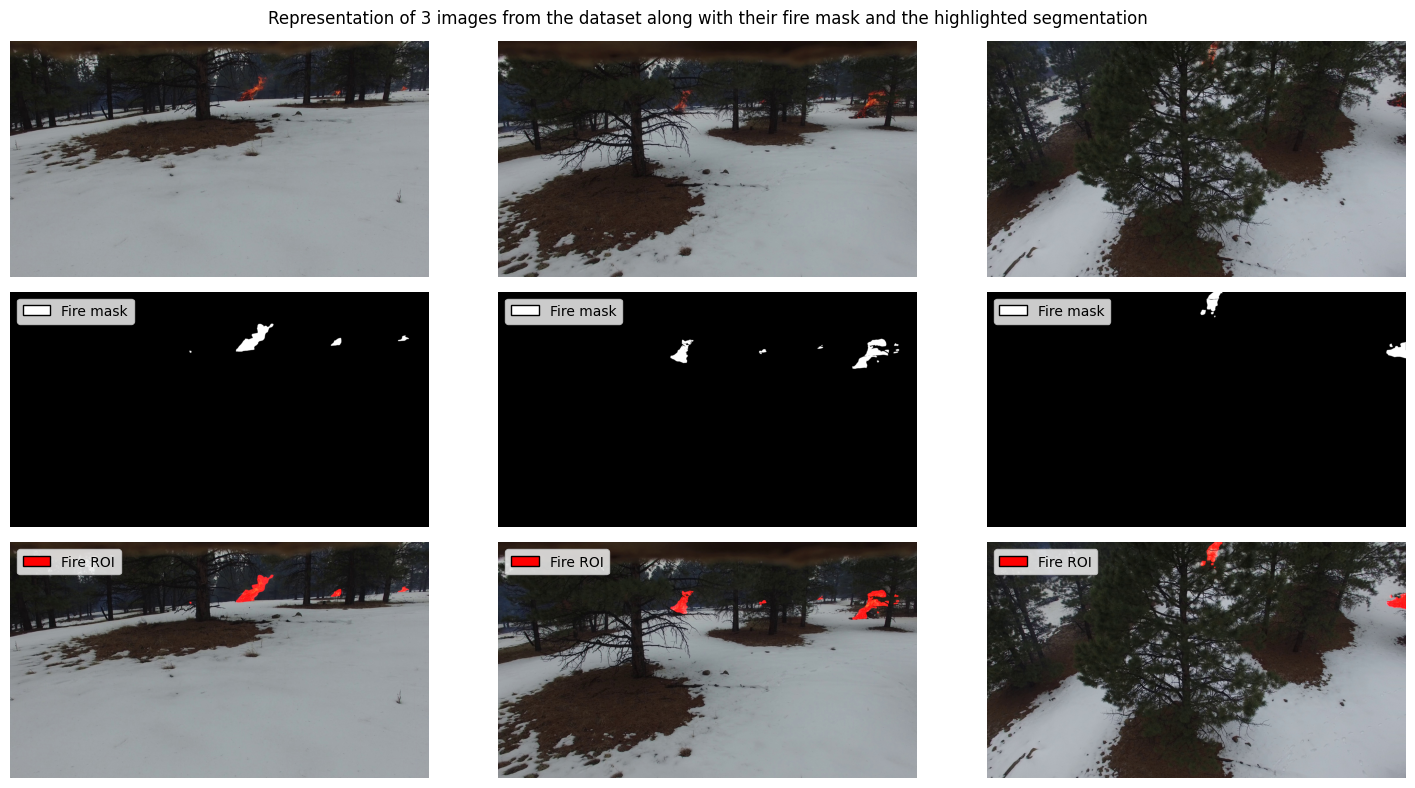

In [13]:
from src.data.analysis import plot_dataset_samples

plot_dataset_samples(images, masks)

In [18]:
from src.data.dataset_handler import resize_images

# Set the resize shape of the images used to train the model.
RESIZE_SHAPE = (512, 512)
# Set the original shape of the images.
ORIGINAL_SHAPE = images.shape[-3:-1]

# Resize the images and the masks.
images = resize_images(images, resize_shape=RESIZE_SHAPE)
masks = resize_images(masks, resize_shape=RESIZE_SHAPE)

In [19]:
from src.data.dataset_handler import get_train_val_test_dataset_split

(X_train, y_train), (X_val, y_val), (X_test, y_test) = \
    get_train_val_test_dataset_split(images, masks, seed=SEED)

In [20]:
print(f'Train shapes: {X_train.shape}, {y_train.shape}')
print(f'ValIdation shapes: {X_val.shape}, {y_val.shape}')
print(f'Test shapes: {X_test.shape}, {y_test.shape}')

Train shapes: (361, 512, 512, 3), (361, 512, 512)
ValIdation shapes: (64, 512, 512, 3), (64, 512, 512)
Test shapes: (75, 512, 512, 3), (75, 512, 512)


## Model

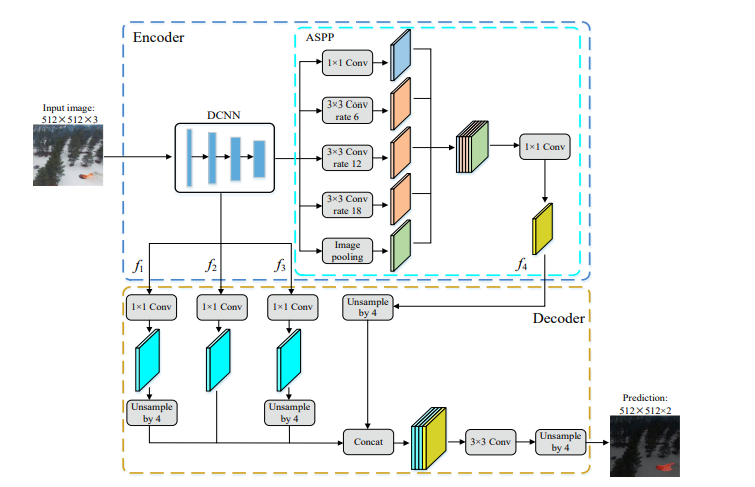

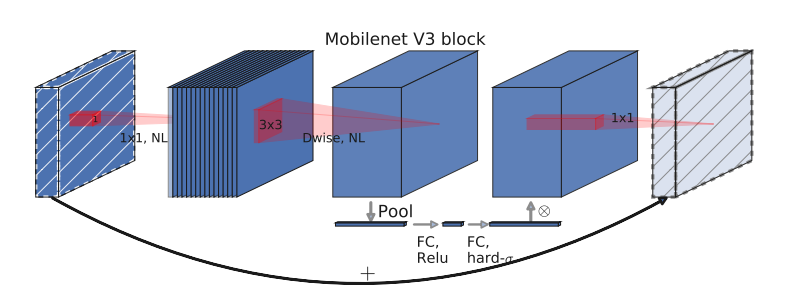

In [21]:
from torch import cuda

# Set the device on which the model operations are performed.
DEVICE = 'cuda' if cuda.is_available() else 'cpu'

# Set the batch size used for training.
TRAIN_BATCH_SIZE = 4
# Set the batch size used for evaluation.
EVAL_BATCH_SIZE = 4

In [22]:
from src.model.model import FireSegmentationModel

model = FireSegmentationModel(RESIZE_SHAPE, DEVICE)

In [23]:
from torchinfo import summary

summary(model, input_size=(TRAIN_BATCH_SIZE, 3, *RESIZE_SHAPE))

c:\Users\riccardo\AppData\Local\Programs\Python\Python310\lib\site-packages\torchinfo\torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
c:\Users\riccardo\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                                  Output Shape              Param #
FireSegmentationModel                                   [4, 2, 512, 512]          --
├─Encoder: 1-1                                          [4, 16, 256, 256]         --
│    └─DCNN: 2-1                                        [4, 16, 256, 256]         --
│    │    └─Sequential: 3-1                             [4, 16, 256, 256]         464
│    │    └─Sequential: 3-2                             [4, 16, 256, 256]         752
│    │    └─Sequential: 3-3                             [4, 24, 128, 128]         7,880
│    │    └─Sequential: 3-4                             [4, 40, 64, 64]           56,168
│    │    └─Sequential: 3-5                             [4, 160, 32, 32]          2,388,040
│    └─ASPP: 2-2                                        [4, 256, 32, 32]          --
│    │    └─Sequential: 3-6                             [4, 256, 32, 32]          41,472
│    │    └─Sequential: 3-7             

## Dataset


In [24]:
train_mean = np.mean(X_train, axis=(-4, -3, -2))
train_std = np.std(X_train, axis=(-4, -3, -2))

In [25]:
CHANNELS = ['B', 'G', 'R']

print('Mean of the training images per channel:',
      "; ".join([f'{c}: {m:.2f}' for c, m in zip(CHANNELS, train_mean)]))
print('Standard deviation of the training images per channel:',
      "; ".join([f'{c}: {m:.2f}' for c, m in zip(CHANNELS, train_std)]))

Mean of the training images per channel: B: 95.69; G: 95.72; R: 94.81
Standard deviation of the training images per channel: B: 67.96; G: 64.10; R: 59.81


In [26]:
from src.data.dataloaders import get_dataloader

train_loader = get_dataloader(
    X_train, y_train, train_mean, train_std, batch_size=TRAIN_BATCH_SIZE,
    shuffle=True, apply_augmentation=True)

val_loader = get_dataloader(
    X_val, y_val, train_mean, train_std, batch_size=EVAL_BATCH_SIZE,
    shuffle=False, apply_augmentation=False)

test_loader = get_dataloader(
    X_test, y_test, train_mean, train_std, batch_size=EVAL_BATCH_SIZE,
    shuffle=False, apply_augmentation=False)

In [27]:
# Remove the images and masks from memory.
del images
del masks

## Loss, Optimizer, Scheduler

In [28]:
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
from src.training.lion import Lion

# Set the optimizer.
optimizer = Lion(model.parameters(), lr=1e-4, weight_decay=1e-5)

# Set the Learning Rate Schedulers.
step_lr_scheduler = StepLR(optimizer, gamma=.94, step_size=1)
plateau_lr_scheduler = ReduceLROnPlateau(
    optimizer, factor=.98, patience=300, threshold=1e-6)
lr_schedulers=[step_lr_scheduler, plateau_lr_scheduler]

## Training Loop

In [29]:
import os
from src.training.utils import Checkpoint

# Set the number of epochs.
EPOCHS = 30

# Set the validation step.
VAL_STEP = 200

# Set the checkpoint monitor.
checkpoint = Checkpoint(os.path.join('.', 'model', 'checkpoints.pth'))

In [30]:
from src.training.training import train

history = train(model, optimizer, train_loader, val_loader, EPOCHS, VAL_STEP,
                DEVICE, checkpoint, lr_schedulers, reload_best_weights=True)

Epoch 1/2
[1/90] - 2s 1818ms/step - train { loss: 0.0589 - MPA: 50.5% - MiOU: 14.2% } - lr: 0.0001              
[2/90] - 3s 1346ms/step - train { loss: 0.0631 - MPA: 52.7% - MiOU: 19% } - lr: 0.0001              
[3/90] - 4s 1204ms/step - train { loss: 0.0588 - MPA: 57.1% - MiOU: 22.4% } - lr: 0.0001              
[4/90] - 4s 1117ms/step - train { loss: 0.0576 - MPA: 55% - MiOU: 25.1% } - lr: 0.0001              
[5/90] - 5s 1065ms/step - train { loss: 0.054 - MPA: 57.6% - MiOU: 27.3% } - lr: 0.0001              
[6/90] - 6s 1025ms/step - train { loss: 0.0515 - MPA: 53.5% - MiOU: 28.2% } - lr: 0.0001              
[7/90] - 7s 1014ms/step - train { loss: 0.0488 - MPA: 52.5% - MiOU: 30.2% } - lr: 0.0001              
[8/90] - 8s 1004ms/step - train { loss: 0.0462 - MPA: 51.5% - MiOU: 31.9% } - lr: 0.0001              
[9/90] - 9s 985ms/step - train { loss: 0.044 - MPA: 53.3% - MiOU: 33.5% } - lr: 0.0001              
[10/90] - 10s 980ms/step - train { loss: 0.0417 - MPA: 54.2% - MiOU: 3

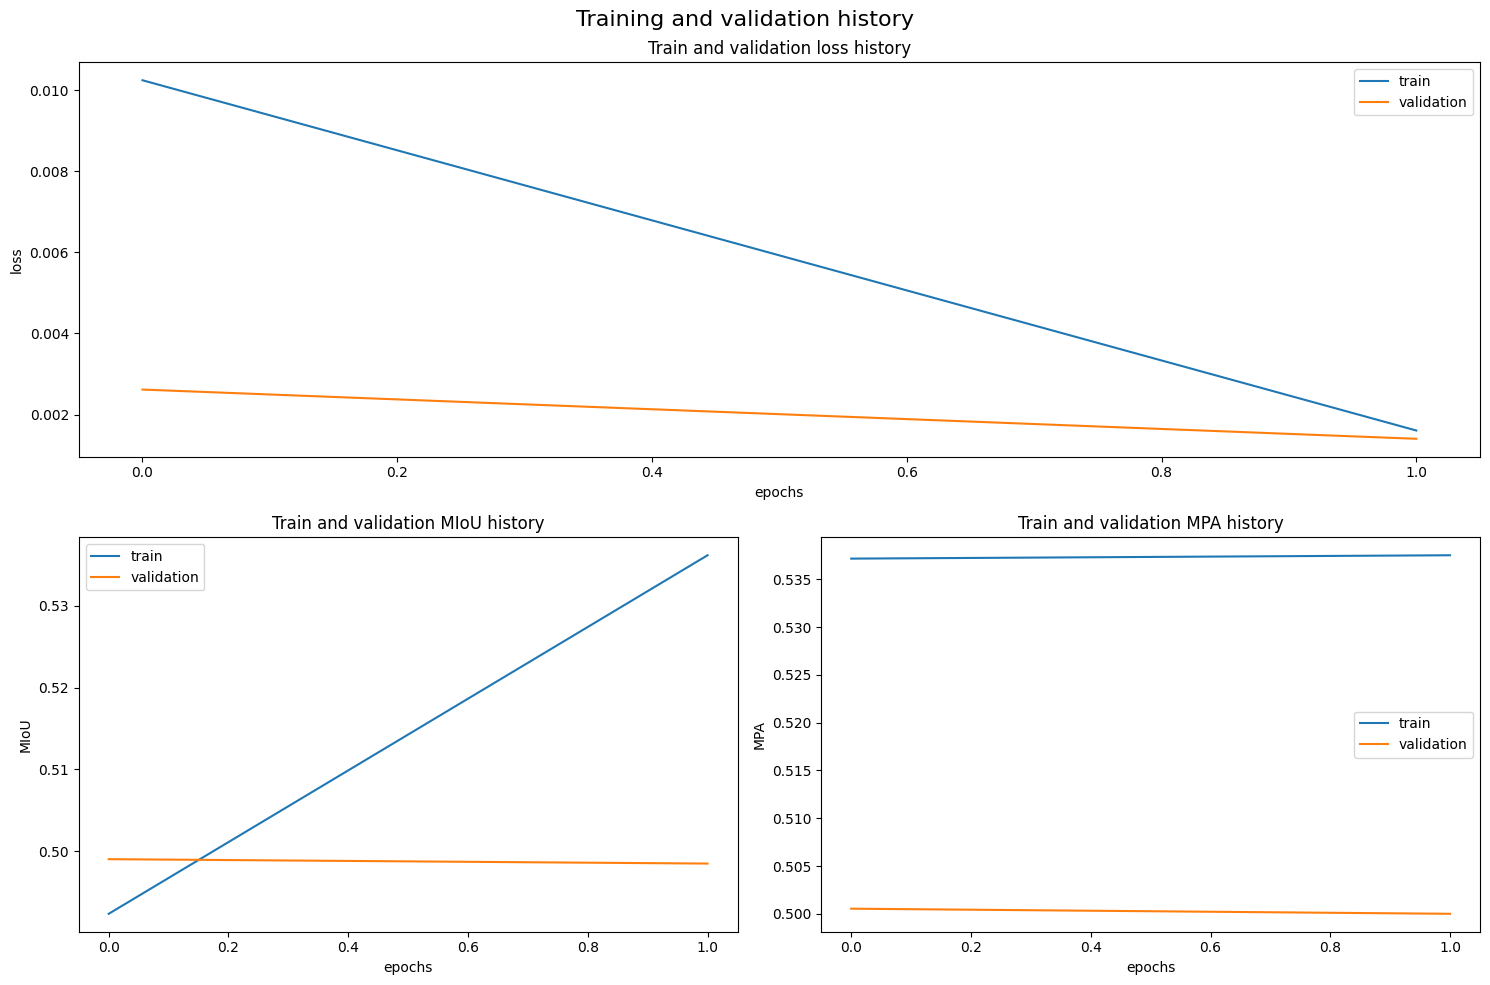

In [68]:
from src.training.analysis import plot_training_history

plot_training_history(history)

In [31]:
from src.training.training import validate

# Get the validation evaluation results.
val_loss, val_mpa, val_miou, val_fps = validate(
    model, val_loader, DEVICE, resize_evaluation_shape=ORIGINAL_SHAPE)

In [32]:
print('Validation loss:', f'{val_loss:.5f}')
print('Validation MPA:', f'{val_mpa:.3f}')
print('Validation MIoU:', f'{val_miou:.3f}')
print('Validation FPS:', f'{val_fps:.3f}')

Validation loss: 0.0026159
Validation MPA: 0.501
Validation MIoU: 0.499
Validation FPS: 193


In [33]:
from src.training.training import validate

# Get the test evaluation results.
test_loss, test_mpa, test_miou, test_fps = validate(
    model, test_loader, DEVICE, resize_evaluation_shape=ORIGINAL_SHAPE)

In [34]:
print('Test loss:', f'{test_loss:.5f}')
print('Test MPA:', f'{test_mpa:.3f}')
print('Test MIoU:', f'{test_miou:.3f}')
print('Test FPS:', f'{test_fps:.3f}')

Test loss: 0.0025977
Test MPA: 0.5
Test MIoU: 0.499
Test FPS: 191


# Results

In [60]:
from src.prediction.predict import predict
from src.data.dataset_handler import resize_images

# Get the model test predictions to the original size.
y_pred = predict(model, test_loader, DEVICE,
                 resize_evaluation_shape=ORIGINAL_SHAPE)
# Get the test images to their original size.
X = resize_images(X_test, ORIGINAL_SHAPE[::-1])[:len(y_pred)]

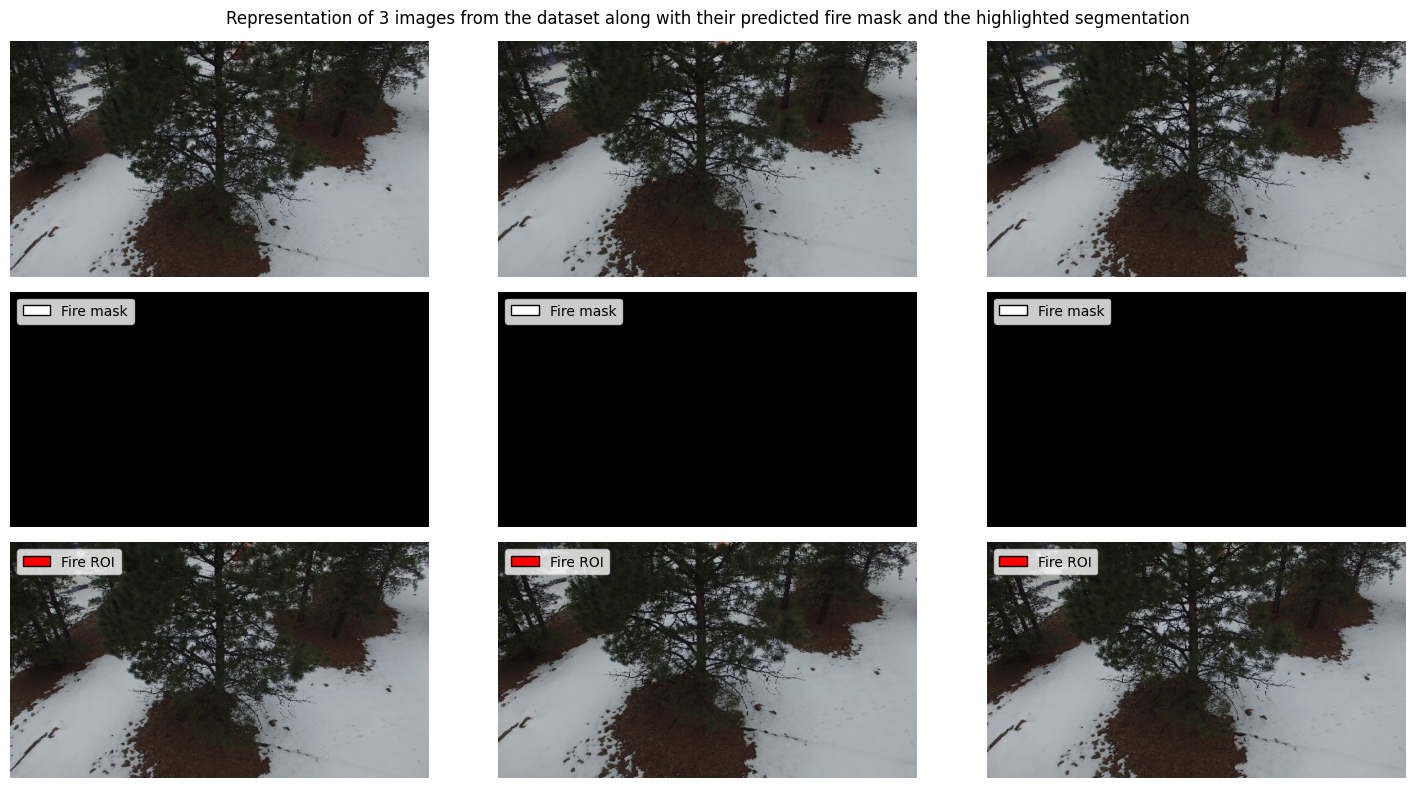

In [67]:
from src.data.analysis import plot_dataset_samples

plot_dataset_samples(
    X, y_pred,
    title='Representation of 3 images from the dataset '
    'along with their predicted fire mask and the highlighted segmentation')